# Using the O'Neil (2019) Observation-based Priors

by Sarah Blunt and Clarissa R. Do Ó (2024)


### Background on Observable-based Priors 

Observable-based priors are a different set of priors from the standard "parameter" priors that most orbit fitting codes (including orbitize!) use. Here, rather than placing uniform priors on orbital parameters such as eccentricity and periastron passage, uniform priors are placed on the "observables" of the orbit (which are linearly related to the measured positions of the companion).  The idea behind these priors is that there is an equal probability (i.e., uniform probability) of obtaining observations in the regions of parameter space that are possible to observe. For that reason, observable priors present uniformity in the orbital observables, which can be transformed back to orbital parameters.

The paper where these priors are introduced is  <a href = "https://ui.adsabs.harvard.edu/abs/2019AJ....158....4O/abstract"> O'Neil et al 2019</a>, so if you use this functionality **please cite that paper.**

Note: The observable-based priors are set up in a different orbital basis from orbitize!'s basis. The main difference is that they use period P rather than semi-major axis a and periastron passage epoch (in years) rather than the unitless parameter $\tau$.


In [1]:
import numpy as np
import multiprocessing as mp
from astropy.time import Time

from orbitize import read_input, priors, system, sampler, DATADIR

### Set up Orbit

Let's set up our System class, which holds all the info about the planetary system we're modeling. We will use the object HD 206893 B as an example orbit for this tutorial. 

We begin but reading in the astrometry data, and providing the system's mass and parallax. For this tutorial, and in general, one should use RA and Dec astrometry measurements rather than separation/P.A.

Importantly, to use the observation-based priors in orbitize!, **you must also use the "ObsPriors"
fitting basis** (as shown below).

In [2]:
filename = "{}/hd206893b.csv".format(DATADIR)

# system parameters
num_secondary_bodies = 1
system_mass = 1.35  # [Msol]
plx = 24.5272375  # [mas]

data_table = read_input.read_file(filename)

mySystem = system.System(
    1, data_table, system_mass, plx, mass_err=0, plx_err=0, fitting_basis="ObsPriors"
)
mySystem.basis

print("We are fitting using this orbital basis: {}".format(mySystem.param_idx))

We are fitting using this orbital basis: {'per1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tp1': 5, 'plx': 6, 'mtot': 7}


Let's check if the data is being read correctly!

In [3]:
mySystem.data_table

epoch,object,quant1,quant1_err,quant2,quant2_err,quant12_corr,quant_type,instrument
float64,int64,float64,float64,float64,float64,float64,bytes5,bytes5
57298.0,1,-253.72,2.98,92.35,2.85,nan,radec,defrd
57606.0,1,-236.63,9.77,127.94,9.18,nan,radec,defrd
57645.0,1,-234.52,1.79,123.39,1.03,nan,radec,defrd
57946.0,1,-210.76,1.94,152.09,1.88,nan,radec,defrd
58276.0,1,-167.49,1.61,180.87,16.97,nan,radec,defrd
58287.0,1,-177.67,1.67,174.6,1.67,nan,radec,defrd
58365.0,1,-165.7,3.28,185.33,3.66,nan,radec,defrd
58368.0,1,-170.38,2.52,185.94,2.74,nan,radec,defrd
58414.0,1,-161.64,13.6,176.21,14.31,nan,radec,defrd


## Modify Priors

We'll next modify the priors on `per1`, `ecc1`, and `tp1` to be the O'Neil observation-based prior. For more info on modifying priors in `orbitize!`, check out the [modifying priors tutorial](https://orbitize.readthedocs.io/en/latest/tutorials/Modifying_Priors.html). 

The observation-based prior requires information about the error bars and observation times of your data points, so we need to pass those in.

In [4]:
ra_err = mySystem.data_table["quant1_err"]
dec_err = mySystem.data_table["quant1_err"]
epochs = np.array(mySystem.data_table["epoch"])

lower_tp_lim = Time(2000, format="decimalyear").mjd
upper_tp_lim = Time(2100, format="decimalyear").mjd

# define the `ObsPrior` object
my_obsprior = priors.ObsPrior(
    ra_err,
    dec_err,
    epochs,
    system_mass,
    period_lims=(
        0.0,
        100,
    ),  # these two "limits" on period and periastron passage time are optional, but aid convergence.
    tp_lims=(
        lower_tp_lim,
        upper_tp_lim,
    ),
)

# set the priors on `per1`, `ecc1`, and `tp1` to point to this object
for i in [
    mySystem.param_idx["per1"],
    mySystem.param_idx["ecc1"],
    mySystem.param_idx["tp1"],
]:
    mySystem.sys_priors[i] = my_obsprior

mySystem.sys_priors

/home/sblunt/miniconda3/envs/python3.12/lib/python3.12/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/sblunt/miniconda3/envs/python3.12/lib/python3.12/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/sblunt/miniconda3/envs/python3.12/lib/python3.12/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


[ObsPrior, ObsPrior, Sine, Uniform, Uniform, ObsPrior, 24.5272375, 1.35]

### Run MCMC!

Let's run this orbit fit!

Starting Burn in


/home/sblunt/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array) / normalization)
/home/sblunt/orbitize/orbitize/priors.py:482: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array) / normalization)


10/10 steps of burn-in complete
Burn in complete. Sampling posterior now.
10/10 steps completed
Run complete


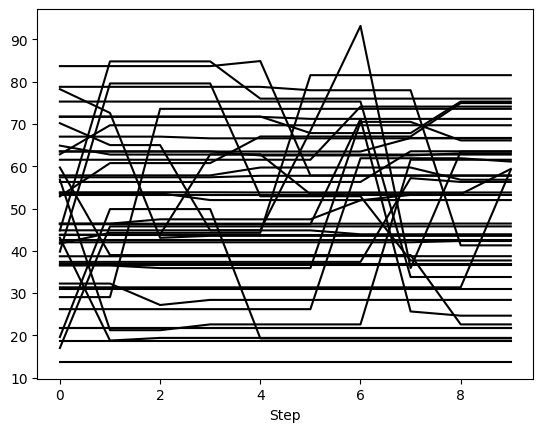

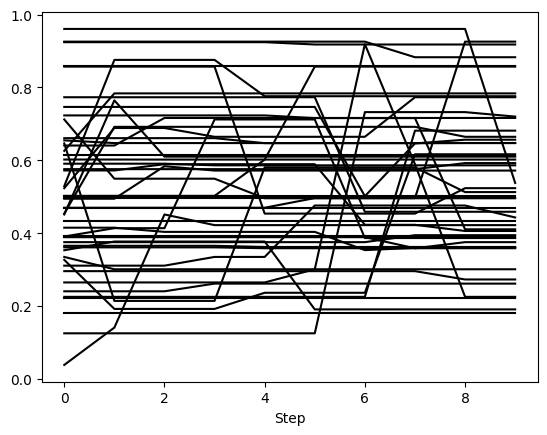

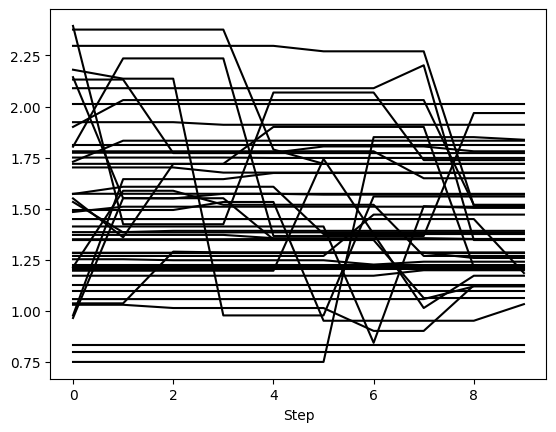

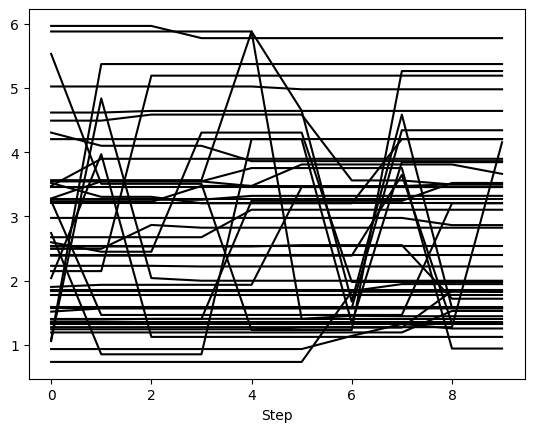

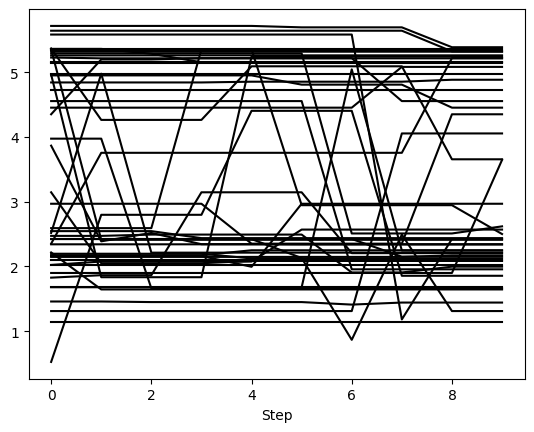

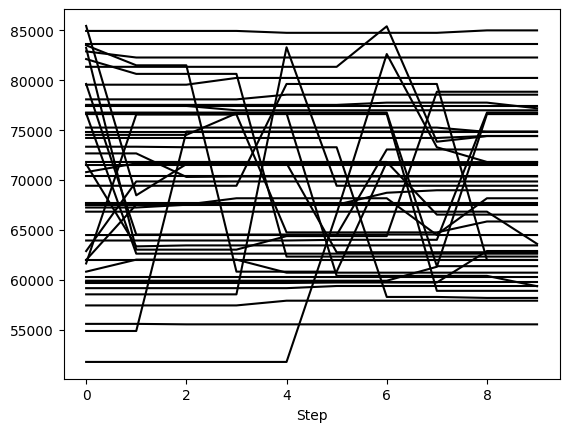

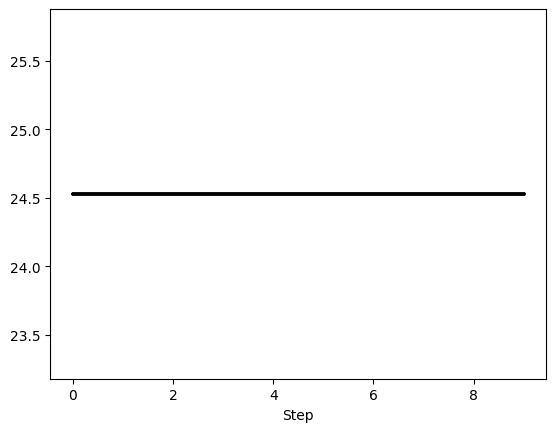

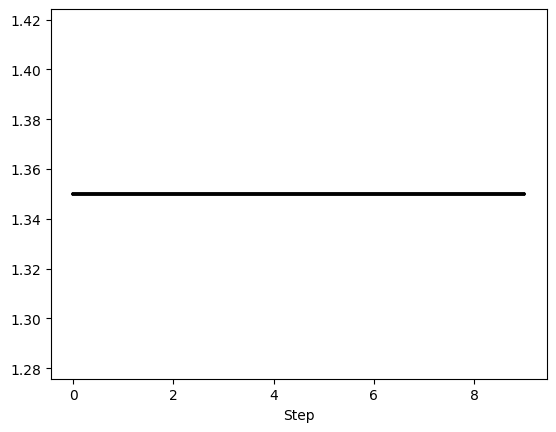

In [5]:
# these are the MCMC parameters I'd use if I wanted to publish this orbit fit.
# num_temps = 5
# num_walkers = 50
# num_threads = 2
# n_steps_per_walker = 100000
# n_burn_steps = 4000

# since this is a tutorial, let's only run it for a few steps
num_temps = 5
num_walkers = 50
num_threads = 2
n_steps_per_walker = 10
n_burn_steps = 10

# create an MCMC object using our newly modified System object
myMCMC = sampler.MCMC(
    mySystem, num_temps=num_temps, num_walkers=num_walkers, num_threads=num_threads
)

myMCMC.check_prior_support()
myMCMC.run_sampler(
    n_steps_per_walker * num_walkers, burn_steps=n_burn_steps, examine_chains=True
)

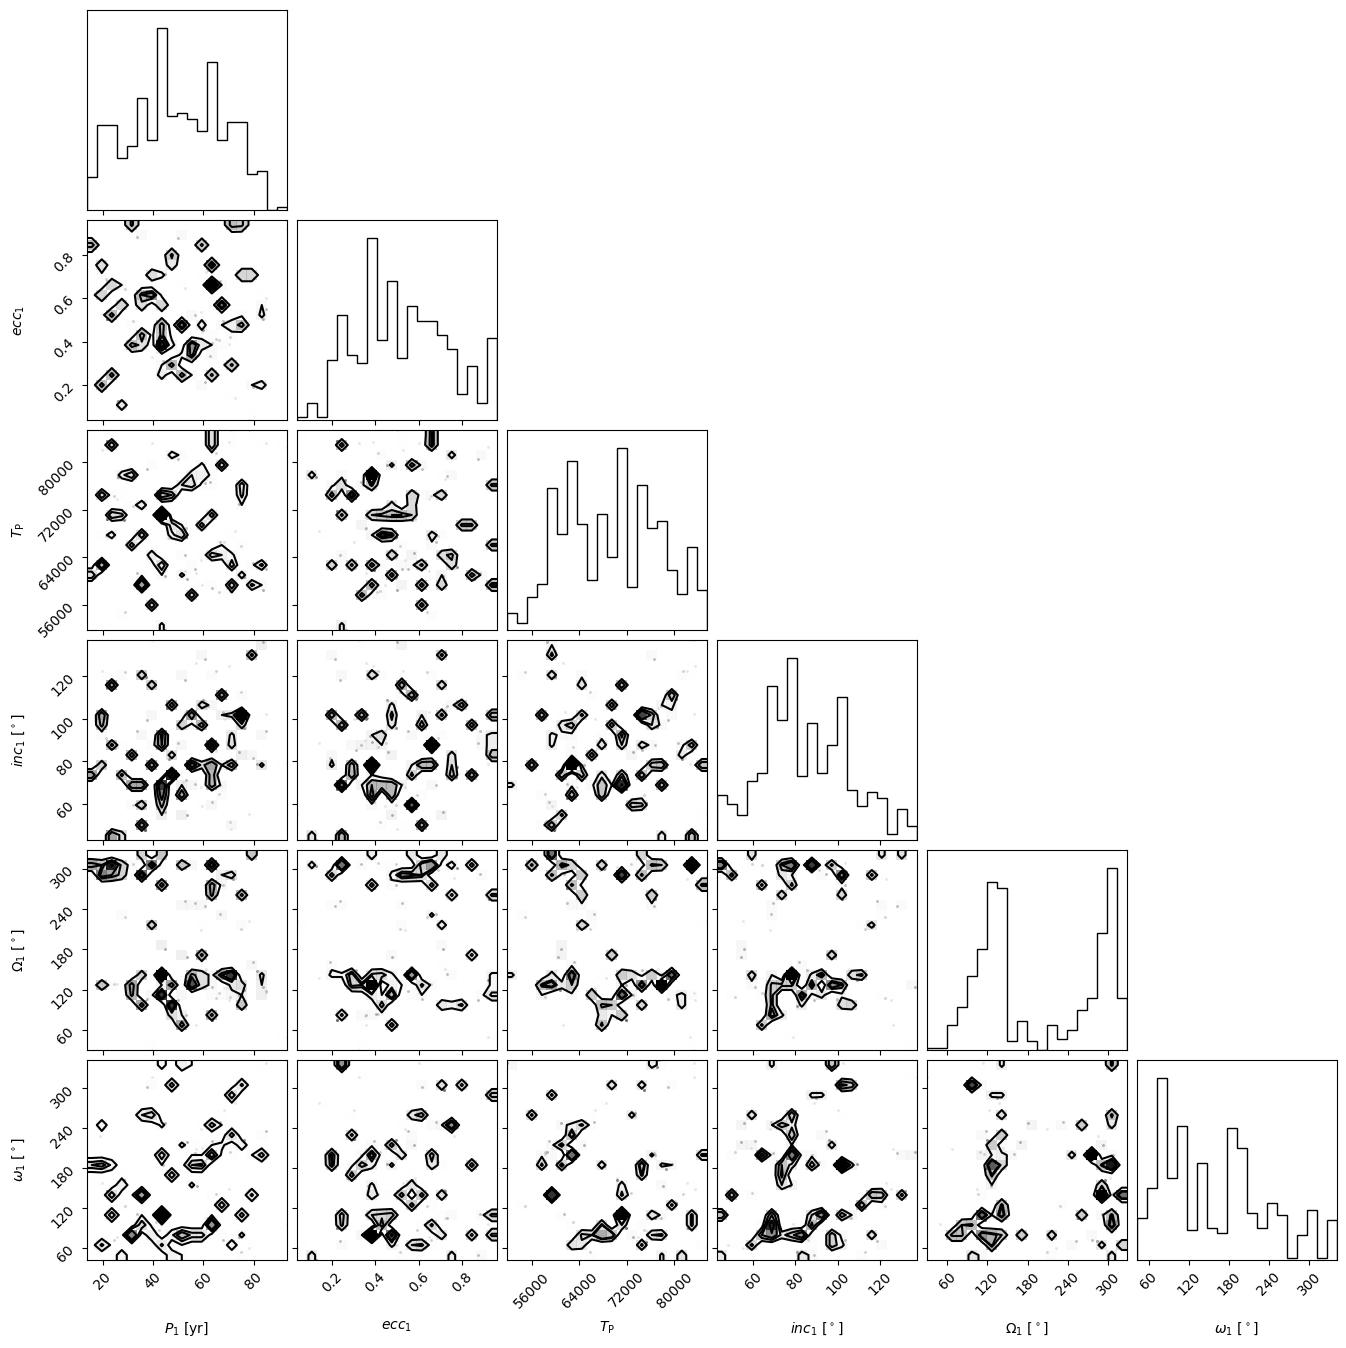

In [6]:
my_corner = myMCMC.results.plot_corner(
    param_list=["per1", "ecc1", "tp1", "inc1", "pan1", "aop1"]
)